#Imports and Dataset

In [ ]:
import numpy as np
import PIL
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download mikhailma/test-dataset -p /content/ --unzip

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 99% 391M/393M [00:17<00:00, 24.5MB/s]
100% 393M/393M [00:17<00:00, 23.1MB/s]


In [ ]:
from sklearn.model_selection import train_test_split
import shutil, os

orignal_data_path = "/content/Google_Recaptcha_V2_Images_Dataset/images"
edited_data_path = "/content/GRV2_Dataset"

os.mkdir(f"{edited_data_path}")
os.mkdir(f"{edited_data_path}/train")
os.mkdir(f"{edited_data_path}/val")

classes = os.listdir(orignal_data_path)
for class_name in classes:
  os.mkdir(f"{edited_data_path}/train/{class_name}")
  os.mkdir(f"{edited_data_path}/val/{class_name}")

train_volume = 0.8
val_volume = 0.2
for class_name in classes:
  image_list = os.listdir(f"{orignal_data_path}/{class_name}")
  lables = [class_name] * len(image_list)
  train, test, _, _ = train_test_split(image_list, lables, test_size=val_volume, random_state = 42)
  for image in image_list:
    if image in train:
      shutil.copy(f"{orignal_data_path}/{class_name}/{image}", f"{edited_data_path}/train/{class_name}/")
    elif image in test:
      shutil.copy(f"{orignal_data_path}/{class_name}/{image}", f"{edited_data_path}/val/{class_name}/")

In [ ]:
data_dir = edited_data_path
model_name = "resnet"
num_classes = 12
batch_size = 8
num_epochs = 15
feature_extract = False

#Resnet

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":

        model_ft = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, use_pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight
	 layer2.3.bn1.

In [ ]:
class_to_index = image_datasets['train'].class_to_idx
classes = list()
for key, value in class_to_index.items():
  classes.append(key)

with open("Classes.txt", "w") as file:
  for i in classes:
    file.write(i + "\n")

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)
torch.save(model_ft.state_dict(), "/content/ResNet34_Finetuned_GCV2")
!cp /content/ResNet34_Finetuned_GCV2 /content/drive/MyDrive/ColabData/
!cp /content/Classes.txt /content/drive/MyDrive/ColabData/

Epoch 0/14
----------
train Loss: 1.2662 Acc: 0.5841
val Loss: 0.7671 Acc: 0.7469

Epoch 1/14
----------
train Loss: 0.9705 Acc: 0.6775
val Loss: 0.5668 Acc: 0.8158

Epoch 2/14
----------
train Loss: 0.8857 Acc: 0.7112
val Loss: 0.5253 Acc: 0.8426

Epoch 3/14
----------
train Loss: 0.8514 Acc: 0.7210
val Loss: 0.5957 Acc: 0.8065

Epoch 4/14
----------
train Loss: 0.7871 Acc: 0.7374
val Loss: 0.5371 Acc: 0.8396

Epoch 5/14
----------
train Loss: 0.7606 Acc: 0.7497
val Loss: 0.5005 Acc: 0.8422

Epoch 6/14
----------
train Loss: 0.7188 Acc: 0.7614
val Loss: 0.4404 Acc: 0.8660

Epoch 7/14
----------
train Loss: 0.7296 Acc: 0.7623
val Loss: 0.5671 Acc: 0.8307

Epoch 8/14
----------
train Loss: 0.6961 Acc: 0.7671
val Loss: 0.4773 Acc: 0.8443

Epoch 9/14
----------
train Loss: 0.6788 Acc: 0.7791
val Loss: 0.5538 Acc: 0.8328

Epoch 10/14
----------
train Loss: 0.6567 Acc: 0.7829
val Loss: 0.5092 Acc: 0.8575

Epoch 11/14
----------
train Loss: 0.6391 Acc: 0.7806
val Loss: 0.4829 Acc: 0.8588

Ep

#For Inference

In [ ]:
def initialize_model(num_classes):
    model_ft = None
    model_ft = models.resnet34()
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    return model_ft

def load_classes(path):
  classes = list()
  with open(path, 'r') as file:
    data = file.readlines()

    for i in data:
      classes.append(i.strip("\n"))
  return classes


num_classes = 12
input_size = 224
model_folder = "/content/drive/MyDrive/ColabData/"
classes = load_classes(model_folder+"Classes.txt")
finetuned_model = initialize_model(num_classes)
finetuned_model.load_state_dict(torch.load(model_folder + "ResNet34_Finetuned_GCV2"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
finetuned_model.to(device)
finetuned_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Bus with confidence score of 0.9999321699142456


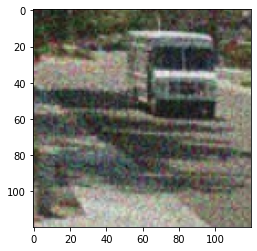

In [ ]:
from PIL import Image

def transform_image(image):
  my_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  image = Image.open(image_path).convert('RGB')
  return my_transforms(image).unsqueeze(0)

def get_prediction(image):
    tensor = transform_image(image)
    tensor=tensor.to(device)
    output = finetuned_model.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, clas = torch.max(probs, 1)
    return conf.item(), classes[clas.item()]


image_path="/content/GRV2_Dataset/val/Bus/Bus (1022).png"
image = plt.imread(image_path)
confidence, class_name = get_prediction(image)
print("{} with confidence score of {}".format(class_name, confidence))
plt.imshow(image)

In [ ]:
image_path="/content/GRV2_Dataset/val/Bridge/Bridge (131).png"
image = plt.imread(image_path)
confidence, class_name = get_prediction(image)
print("{} with confidence score of {}".format(class_name, confidence))
plt.imshow(image)

Bus
